In [24]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm

In [2]:
def get_data(symbol, after, period='1h'):

    #period input, kraken takes data by minutes
    
    timeframes = {
        '3min': 3,
        '5min': 5,
        '15min': 15,
        '1h': 60,
        '3h': 180,
        '4h': 240,
        '1d': 1440
    }
    
    #takes 'after' function input and converts to unix timestamp so we can use for api
    #assigns 'interval' variable to period input
    
    tme = after
    interval = timeframes.get(period)
    
    tme = str(tme)
    since_obj = datetime.strptime(tme, '%Y-%m-%d %H:%M:%S')
    since = int(since_obj.timestamp())
    
    #get data
    
    url = f'https://api.kraken.com/0/public/OHLC?pair={symbol}&since={since}&interval={interval}'.format(symbol=symbol, since = since, interval = interval)
    
    resp = requests.get(url)
    resp.raise_for_status()
    data = resp.json()
    
    #parse through api return and set up data frame with columns and time index
    
    df = pd.DataFrame(data['result'][str(symbol)], columns=['Time', 'OpenPrice', 'HighPrice', 'LowPrice', 'ClosePrice', 'VWAP','Volume', 'Transactions'])
    df['Time'] = pd.to_datetime(df['Time'], unit='s')
    df.set_index('Time', inplace=True)
    
    #edits to the data frame, we only really want close price

    df[str(symbol)] = df['ClosePrice']
    df.drop(['OpenPrice', 'HighPrice', 'LowPrice', 'ClosePrice', 'VWAP', 'Volume', 'Transactions'], axis=1, inplace=True)
    df.astype(float)
    df[symbol] = pd.to_numeric(df[symbol], errors = 'coerce')
    

    return df

In [3]:
days_of_week = {0 : 'Monday',
                1 : 'Tuesday',
                2 : 'Wednesday',
                3 : 'Thursday',
                4 : 'Friday',
                5 : 'Saturday',
                6 : 'Sunday'  
                }

In [ ]:
#simple returns

#def daily_szn(pair, after):

    #asset = get_data(symbol = pair, after = after, period = '1d')
    
    #asset_pct_chng = asset.pct_change()
    #asset_pct_chng['Day of Week'] = asset_pct_chng.index.dayofweek
    
    #avg_per_day = asset_pct_chng.groupby('Day of Week')[pair].mean()
    
    #avg_per_day.index = days_of_week.values()
    #avg_per_day = avg_per_day * 100
    
    #return avg_per_day

In [38]:
# revealing what inspired this project. function calculates average return for given asset over allotted time period
# grouped by day of the week
# log returns

def daily_szn2(pair, after):
    
    asset = get_data(symbol = pair, after = after, period = '1d')
    
    asset_pct_chng = np.log(asset/asset.shift(1))
    asset_pct_chng['Day of Week'] = asset_pct_chng.index.dayofweek
    
    avg_per_day = asset_pct_chng.groupby('Day of Week')[pair].mean()
    
    avg_per_day.index = days_of_week.values()
    avg_per_day = avg_per_day * 100
    
    return avg_per_day

In [39]:
btc_avg = daily_szn2(pair = 'XBTUSDT', after = '2023-04-01 00:00:00')
btc_avg

Monday      -0.497002
Tuesday      1.426778
Wednesday   -0.747351
Thursday    -0.594644
Friday       0.022909
Saturday    -0.137899
Sunday       0.135887
Name: XBTUSDT, dtype: float64

In [40]:
sol_avg = daily_szn2(pair = 'SOLUSDT', after = '2023-04-01 00:00:00')
sol_avg

Monday      -1.439700
Tuesday      1.269249
Wednesday   -0.969264
Thursday     0.215030
Friday       1.031436
Saturday    -0.494584
Sunday       0.104541
Name: SOLUSDT, dtype: float64

In [41]:
# difference in means below

In [42]:
mean_diff_sol = abs(sol_avg.loc['Friday'] - sol_avg.loc['Monday'])
mean_diff_sol

2.471135808803669

In [43]:
mean_diff_btc = abs(btc_avg.loc['Tuesday'] - btc_avg.loc['Monday'])
mean_diff_btc

1.9237798529057972

In [ ]:
# we infer that there are some seasonality effects on sol monday/friday and btc monday/tuesday
# we will run some statistical tests to asses linearity and correlation between possible outcomes
# at first glance, simple long/short trade may be best option (i.e. short btc monday, long btc tuesday, short sol
# monday, long sol friday)

In [4]:
# sol data
sol_data = get_data(symbol = 'SOLUSDT', after = '2023-04-01 00:00:00', period = '1d')

sol_pct_chng = np.log(sol_data/sol_data.shift(1))
sol_pct_chng['Day of Week'] = sol_pct_chng.index.dayofweek
sol_pct_chng.set_index('Day of Week', inplace = True)
    
sol_pct_chng = sol_pct_chng * 100
 

# friday returns   
sol_fridays = sol_pct_chng[sol_pct_chng.index == 4]
sol_fridays.index = ['week ' + str(i) for i in range(1, len(sol_fridays) +1)]

#for later, monday returns
sol_mondays = sol_pct_chng[sol_pct_chng.index == 0]
sol_mondays.index = ['week ' + str(i) for i in range(1, len(sol_mondays) +1)]

In [5]:
# btc data
btc_data = get_data(symbol = 'XBTUSDT', after = '2023-04-01 00:00:00', period = '1d')
    
btc_pct_chng = np.log(btc_data/btc_data.shift(1))
btc_pct_chng['Day of Week'] = btc_pct_chng.index.dayofweek
btc_pct_chng.set_index('Day of Week', inplace = True)
    
btc_pct_chng = btc_pct_chng * 100
   
# tuesday returns
btc_tuesdays = btc_pct_chng[btc_pct_chng.index == 1]
btc_tuesdays.index = ['week ' + str(i) for i in range(1, len(btc_tuesdays) +1)]  

#for later, monday returns
btc_mondays = btc_pct_chng[btc_pct_chng.index == 0]
btc_mondays.index = ['week ' + str(i) for i in range(1, len(btc_mondays) +1)]

In [ ]:
# Is ther correlation between performance of sol on fridays vs. performance of btc on tuesdays?

In [37]:
tf_corr_coef, tf_p_val = stats.pearsonr(btc_tuesdays['XBTUSDT'], sol_fridays['SOLUSDT'])
print(f'corr coef = {tf_corr_coef}')
print(f'pval = {tf_p_val}')

corr coef = -0.39283149397258116
pval = 0.07053009848017111


In [7]:
# no real correlation between longing sol on fridays vs. longing btc on tuesdays,
# if anything, we see slight decorrelation between returns of sol on fridays and btc on tuesdays
# may research this later, not within scope of this project and may be due to other market conditions

In [8]:
# function calculates difference of returns between two days for a given asset over alotted time period.

def diff(pair, after, day_1, day_2):
    
    # get data and set up df with pct change, indexed by day of the week integers, as seen prior
    
    asset = get_data(symbol = pair, after = after, period = '1d')
    
    asset_pct_chng = np.log(asset/asset.shift(1))
    asset_pct_chng['Day of Week'] = asset_pct_chng.index.dayofweek
    asset_pct_chng.set_index('Day of Week', inplace = True)
    
    asset_pct_chng = asset_pct_chng * 100
    
    # parses through df and groups returns by day of the week into separate series
    
    mondays = asset_pct_chng[asset_pct_chng.index == 0]
    mondays.index = ['week ' + str(i) for i in range(1, len(mondays) +1)] 
    
    tuesdays = asset_pct_chng[asset_pct_chng.index == 1]
    tuesdays.index = ['week ' + str(i) for i in range(1, len(tuesdays) +1)]
    
    wednesdays = asset_pct_chng[asset_pct_chng.index == 2]
    wednesdays.index = ['week ' + str(i) for i in range(1, len(wednesdays) +1)]
    
    thursdays = asset_pct_chng[asset_pct_chng.index == 3]
    thursdays.index = ['week ' + str(i) for i in range(1, len(thursdays) +1)]
    
    fridays = asset_pct_chng[asset_pct_chng.index == 4]
    fridays.index = ['week ' + str(i) for i in range(1, len(fridays) +1)]
    
    saturdays = asset_pct_chng[asset_pct_chng.index == 5]
    saturdays.index = ['week ' + str(i) for i in range(1, len(saturdays) +1)]
    
    sundays = asset_pct_chng[asset_pct_chng.index == 6]
    sundays.index = ['week ' + str(i) for i in range(1, len(sundays) +1)]
    
    # calculate the desired difference
    
    week_dict = {'mondays' : mondays,
                 'tuesdays' : tuesdays,
                 'wednesdays' : wednesdays,
                 'thursdays' : thursdays,
                 'fridays' : fridays,
                 'saturdays' : saturdays,
                 'sundays' : sundays
                }
    
    if day_1 in week_dict and day_2 in week_dict:
        diff = (week_dict[day_2] - week_dict[day_1])
        
        
    
    return diff

In [9]:
# in other words, function shows returns of long/short strategy by week. stored in variables below

sol_szn = diff(pair = 'SOLUSDT', after = '2023-04-01 00:00:00', day_1 = 'mondays', day_2 = 'fridays')
btc_szn = diff(pair = 'XBTUSDT', after = '2023-04-01 00:00:00', day_1 = 'mondays', day_2 = 'tuesdays')

In [ ]:
# Is there correlation between returns of long/short btc and long/short sol?

In [35]:
diff_corr_coef, diff_p_val = stats.pearsonr(btc_szn['XBTUSDT'], sol_szn['SOLUSDT'])
print(f'corr coef = {diff_corr_coef}')
print(f'pval = {diff_p_val}')

corr coef = -0.02893202556944621
pval = 0.8983007614734968


In [ ]:
# no correlation significance at all between the returns of long/short sol friday/monday and 
# long short btc tuesday/monday... about as random as you can get I'd say

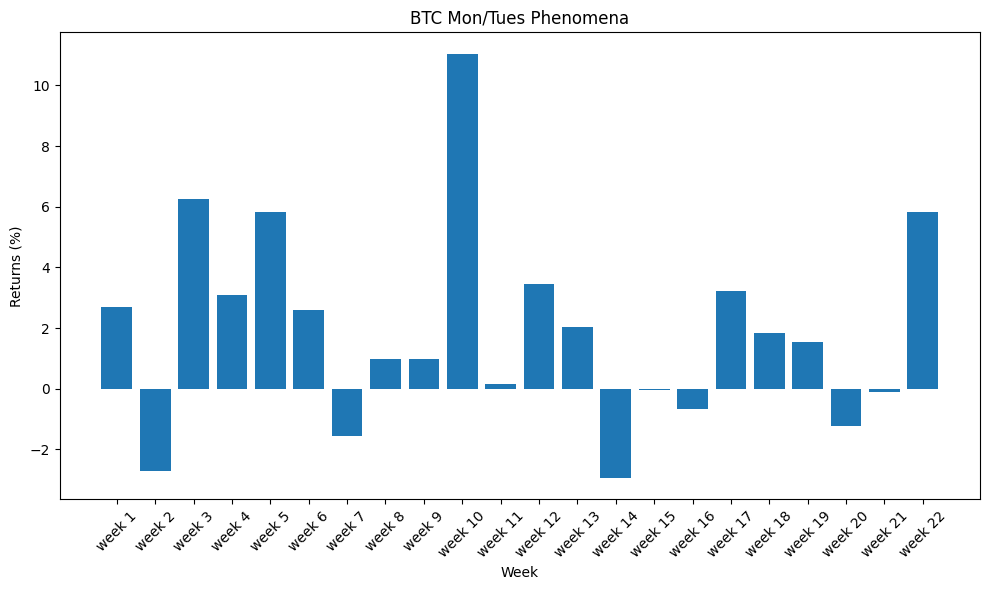

In [11]:
# visualization of btc mon/tues phenomena (assuming short monday, long tuesday, returns visualized)
# aka difference in returns

plt.figure(figsize = (10,6))
plt.bar(btc_szn.index, btc_szn['XBTUSDT'])
plt.xlabel('Week')
plt.ylabel('Returns (%)')
plt.title('BTC Mon/Tues Phenomena')

plt.xticks(rotation = 45)
plt.tight_layout()

plt.show()

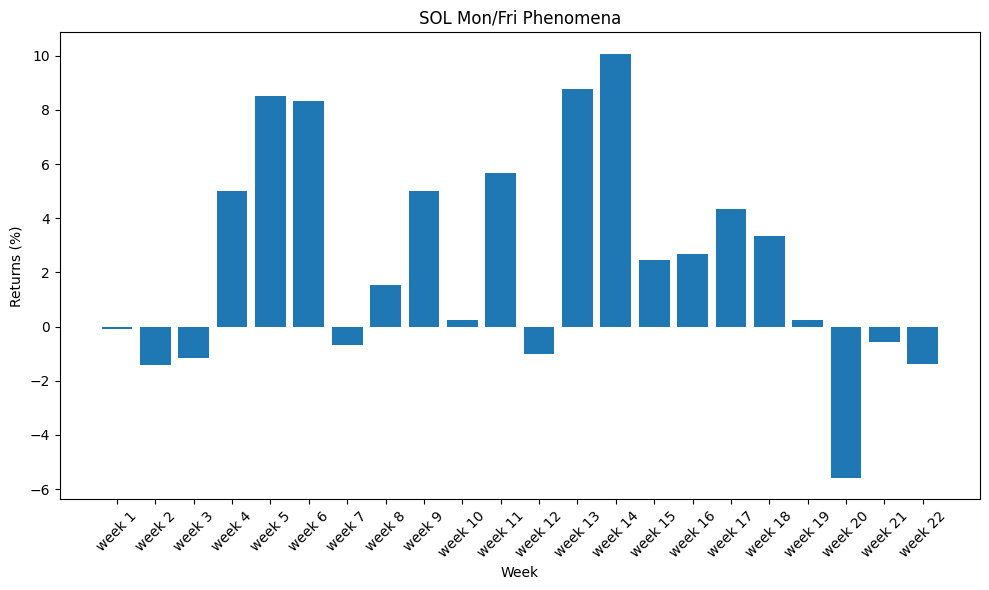

In [12]:
# visualization of sol mon/fri phenomena (assuming short monday, long friday, returns visualized)
# aka difference in returns

plt.figure(figsize = (10,6))
plt.bar(sol_szn.index, sol_szn['SOLUSDT'])
plt.xlabel('Week')
plt.ylabel('Returns (%)')
plt.title('SOL Mon/Fri Phenomena')

plt.xticks(rotation = 45)
plt.tight_layout()

plt.show()

In [19]:
# linear regression on sol monday vs. friday and btc monday vs. tuesday
# is there anything signficant or linear about the success of monday's trade vs. friday's/tuesday's

In [20]:
sol_mondays_neg = (sol_mondays * (-1))

x_1 = sm.add_constant(sol_mondays_neg['SOLUSDT'])
y_1 = sol_fridays['SOLUSDT']

model_1 = sm.OLS(y_1, x_1).fit()

print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                SOLUSDT   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.457
Date:                Sat, 02 Sep 2023   Prob (F-statistic):              0.242
Time:                        12:39:07   Log-Likelihood:                -59.082
No. Observations:                  22   AIC:                             122.2
Df Residuals:                      20   BIC:                             124.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5215      0.891      1.707      0.1

In [22]:
btc_mondays_neg = (btc_mondays * (-1))

x_2 = sm.add_constant(btc_mondays_neg['XBTUSDT'])
y_2 = btc_tuesdays['XBTUSDT']

model_2 = sm.OLS(y_2, x_2).fit()

print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                XBTUSDT   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.7188
Date:                Sat, 02 Sep 2023   Prob (F-statistic):              0.407
Time:                        12:39:59   Log-Likelihood:                -46.832
No. Observations:                  22   AIC:                             97.66
Df Residuals:                      20   BIC:                             99.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3352      0.467      2.857      0.0

In [18]:
# and we see there is no predictive factor here, as expected. Monday's trade outcome does not serve as
# predictor for weight of success on tuesday's/friday's trade

In [ ]:
# next we run t-tests to asses significance of the difference of returns, as portrayed in the histograms above

In [32]:
alpha = 0.05

t_stat, tp_val = stats.ttest_ind(sol_fridays['SOLUSDT'], sol_mondays['SOLUSDT'])

print(f"T-stat: {t_stat}")
print(f"pval: {tp_val}")

T-stat: 2.4461361151674756
pval: 0.01870918838616326


In [33]:
t_stat2, tp_val2 = stats.ttest_ind(btc_tuesdays['XBTUSDT'], btc_mondays['XBTUSDT'])

print(f"T-stat: {t_stat2}")
print(f"pval: {tp_val2}")

T-stat: 2.9953275647566135
pval: 0.004583600634308595


In [ ]:
# So this is *very* significant. We can very confidently reject the null hypothesis and accept the 
# alternative hypothesis that there is a *signficant* difference in the returns of btc on monday vs. tuesday and 
# sol on monday vs. friday.

# While I cannot say with certainty that these phenomena are independent, the severe lack of correlation
# and existence of randomness is enough for me to conclude that these phenomena warrant independent trading 
# strategies regardless of the performance of one or the other (i.e. short monday, long tuesday/friday). 
# Also, one may desire more historical data and more observations before making such conclusions. 
# This project has been created such that it can easily be modified for such an analysis and I have done such an
# analysis with this code prior. This is simply the version of which I chose to upload.

# An important note is that market regimes change very, very often. There is no guarantee that this phenomena
# persists and just because more historical data may validate (or invalidate) the existence of this phenomena,
# does not mean that what has been found in not statistically significant and not actionable today.  

# To reiterate other findings: it is also important to note that just because btc prints a positive/negatve return 
# on tuesday does not necessarily mean solana will print a positive/negative return on friday. Furthermore, 
# just because btc and/or solana prints a positive/negative return on monday does not mean that they 
# will print a positive/negative return on tuesday/friday as well. 

# It may be important to note that we saw a slight decorrelation between the returns of btc on tuesday and
# the returns of sol on friday. Further research may be done to optimize this analysis, but I think sufficient
# research has been done to reveal an executeable edge in the difference of returns for btc on Monday/Tuesday
# and sol on Monday/Friday. In the future, there may be predictability in the phenomena gained from the
# decorrelation factor observed. This may be able to be applied to the risk management of the long trade for sol
# on fridays. Could possibly indicate lower likelihood of success and thus lessen the size of a trade or higher
# likelihood of success and thus increase size. Although, this is getting too far in depth for a rather simple trade
# application which may not even exist for much longer as market regimes change quite often. Furthermore, 
# there is a greater likilhood that the decorrelation observed is due to other market conditions.

# Project codebase will be used in the future to analyze other daily seasonality effects of other assets across
# other days. 

# overall, very happy with my first project.